# Libraries

In [1]:
import os, glob
import random
import numpy as np
import pandas as pd
import multiprocessing
import cv2
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm_notebook as tqdm
from numpy.random import seed
seed(10)
#from tensorflow import random
#random.set_seed(13)
from tensorflow import set_random_seed
set_random_seed(10)
%matplotlib inline

Using TensorFlow backend.


In [3]:
test_imgs_folder = './input/test_images/'
train_imgs_folder = './input/train_images/'
num_cores = multiprocessing.cpu_count()

# Data Generators

## One-hot encoding classes

In [4]:
train_df = pd.read_csv('./input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1


In [6]:
# dictionary for fast access to ohe vectors
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

## Stratified split into train/val

In [7]:
train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), # sorting present classes in lexicographical order, just to be sure
                                        random_state=17)

## Generator class

In [8]:
class DataGenenerator(Sequence):
    def __init__(self, images_list=None, folder_imgs=train_imgs_folder, 
                 batch_size=16, shuffle=True, augmentation=None,
                 resized_height=350, resized_width=525, num_channels=3):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if images_list is None:
            self.images_list = os.listdir(folder_imgs)
        else:
            self.images_list = deepcopy(images_list)
        self.folder_imgs = folder_imgs
        self.len = len(self.images_list) // self.batch_size
        self.resized_height = resized_height
        self.resized_width = resized_width
        self.num_channels = num_channels
        self.num_classes = 4
        self.is_test = not 'train' in folder_imgs
        if not shuffle and not self.is_test:
            self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

    def __len__(self):
        return self.len
    
    def on_epoch_start(self):
        if self.shuffle:
            random.shuffle(self.images_list)

    def __getitem__(self, idx):
        current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
        y = np.empty((self.batch_size, self.num_classes))

        for i, image_name in enumerate(current_batch):
            path = os.path.join(self.folder_imgs, image_name)
            img = cv2.resize(cv2.imread(path), (self.resized_width, self.resized_height), interpolation=cv2.INTER_AREA).astype(np.float32)
            if not self.augmentation is None:
                augmented = self.augmentation(image=img)
                img = augmented['image']
            X[i, :, :, :] = img/255.0
            if not self.is_test:
                y[i, :] = img_2_ohe_vector[image_name]
        return X, y

    def get_labels(self):
        if self.shuffle:
            images_current = self.images_list[:self.len*self.batch_size]
            labels = [img_2_ohe_vector[img] for img in images_current]
        else:
            labels = self.labels
        return np.array(labels)

In [9]:
albumentations_train = Compose([
    VerticalFlip(), HorizontalFlip(), Rotate(limit=20), GridDistortion()
], p=1)

Generator instances

In [10]:
data_generator_train = DataGenenerator(train_imgs, augmentation=albumentations_train, batch_size=12)
data_generator_train_eval = DataGenenerator(train_imgs, shuffle=False, batch_size=12)
data_generator_val = DataGenenerator(val_imgs, shuffle=False, batch_size=12)

# Loss functions and variable learning rates

The callback would be used:
1. to estimate AUC under precision recall curve for each class,
2. to early stop after 5 epochs of no improvement in mean PR AUC,
3. save a model with the best PR AUC in validation,
4. to reduce learning rate on PR AUC plateau.

In [11]:
import keras.backend as K
from keras.losses import binary_crossentropy, mean_squared_error

def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss

def plateau_then_triangular_lr(epocs):
    plateau_steps = 4
    step_size = 2 
    min_lr = 1e-5
    max_lr = 1e-2
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.0**(cycle-1))
    print("NEW learing rate: " + str(lr))
    return lr

def plateau_then_decl_triangular_lr(epocs):
    plateau_steps = 3
    step_size = 2
    min_lr = 1e-6 #1e-5
    max_lr = 5e-4 #5e-3
    
    if epocs < plateau_steps:
        return (min_lr + max_lr)/2
    
    cycle = np.floor(1+epocs/(2*step_size))
    x = np.abs(epocs/step_size - 2*cycle + 1)
    lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1-x))/float(1.2**(cycle-1))
    print("NEW learing rate: " + str(lr))
    return lr


### Load model

In [12]:
import efficientnet.keras as efn 
def get_model():
    K.clear_session()
    base_model =  efn.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(350, 525, 3))
    x = base_model.output
    y_pred = Dense(4, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=y_pred)

model = get_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [13]:
model = model.load_weights('./checkpoints/END-efficientNetB3_350x525_epoch_1_val_pr_auc_0.8489064098425418_weights_only.h5')

In [ ]:
from keras_radam import RAdam
model.compile(optimizer=RAdam(warmup_proportion=0.1, min_lr=1e-5),  loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras_radam import RAdam
import efficientnet.keras
from keras.models import Model, load_model

model = load_model('./checkpoints/END-efficientNetB3_350x525_epoch_1_val_pr_auc_0.8489064098425418.h5',
                  custom_objects={'RAdam': RAdam})
                  
#Custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [ ]:
model.save_weights('./checkpoints/END-efficientNetB3_350x525_epoch_1_val_pr_auc_0.8489064098425418_weights_only.h5')

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Selecting postprocessing thresholds

E:\Anaconda\envs\ML-GPU\lib\site-packages\ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


i = 0
plot it
i = 1
plot it
i = 2
plot it
i = 3
plot it



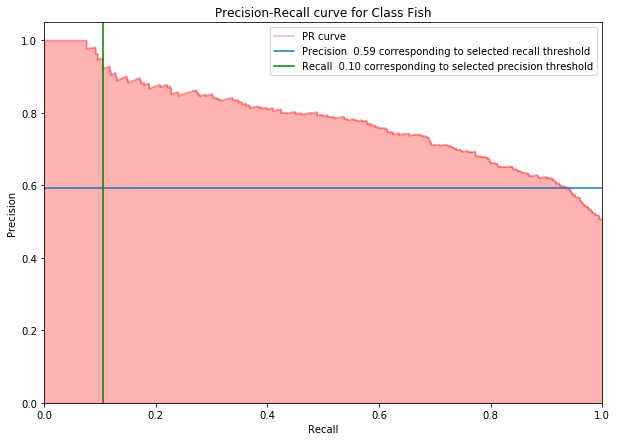

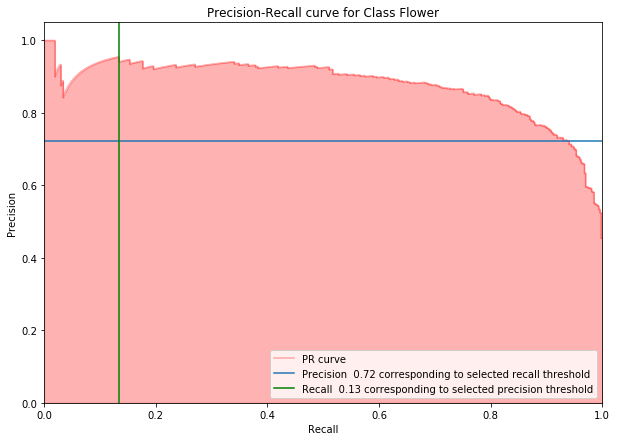

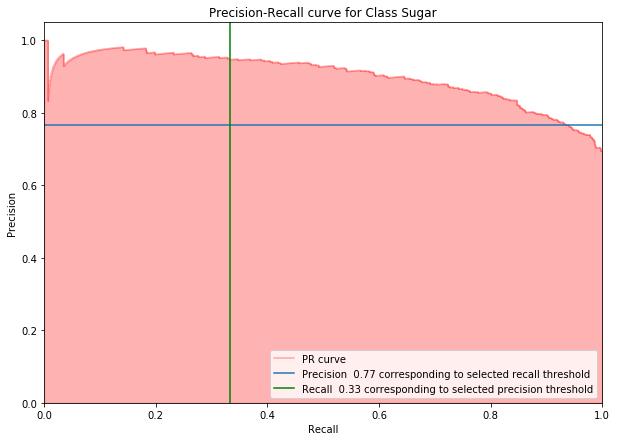

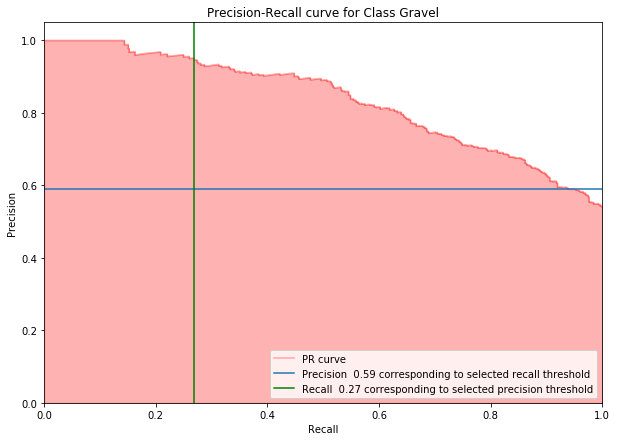

In [12]:
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']
def get_threshold_for_recall(y_true, y_pred, class_i, recall_threshold=0.94, precision_threshold=0.95, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
    i = len(thresholds) - 1
    best_recall_threshold = None
    while best_recall_threshold is None:
        next_threshold = thresholds[i]
        next_recall = recall[i]
        if next_recall >= recall_threshold:
            best_recall_threshold = next_threshold
        i -= 1
        
    # consice, even though unnecessary passing through all the values
    best_precision_threshold = [thres for prec, thres in zip(precision, thresholds) if prec >= precision_threshold]
    if not best_precision_threshold:
        best_precision_threshold = 0.95
    else:
        best_precision_threshold = best_precision_threshold[0]
    
    print("plot it")
    if plot:
        plt.figure(figsize=(10, 7))
        plt.step(recall, precision, color='r', alpha=0.3, where='post')
        plt.fill_between(recall, precision, alpha=0.3, color='r')
        plt.axhline(y=precision[i + 1])
        recall_for_prec_thres = [rec for rec, thres in zip(recall, thresholds) if thres == best_precision_threshold]
        if not recall_for_prec_thres:
            recall_for_prec_thres = 0.94
        else:
            recall_for_prec_thres = recall_for_prec_thres[0]
                                                            
        plt.axvline(x=recall_for_prec_thres, color='g')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(['PR curve', 
                    f'Precision {precision[i + 1]: .2f} corresponding to selected recall threshold',
                    f'Recall {recall_for_prec_thres: .2f} corresponding to selected precision threshold'])
        plt.title(f'Precision-Recall curve for Class {class_names[class_i]}')
    return best_recall_threshold, best_precision_threshold

y_pred = model.predict_generator(data_generator_val, workers=num_cores)
y_true = data_generator_val.get_labels()
recall_thresholds = dict()
precision_thresholds = dict()
for i, class_name in tqdm(enumerate(class_names)):
    print(f'i = {i}')
    recall_thresholds[class_name], precision_thresholds[class_name] = get_threshold_for_recall(y_true, y_pred, i, plot=True)

# Post-processing segmentation submission

Predicting cloud classes for test.

In [13]:
precision_thresholds

{'Fish': 0.97968227,
 'Flower': 0.9983212,
 'Sugar': 0.9776113,
 'Gravel': 0.9379425}

In [14]:
recall_thresholds

{'Fish': 0.16933104,
 'Flower': 0.16213542,
 'Sugar': 0.3476548,
 'Gravel': 0.21943301}

{'Fish': 0.0, 'Flower': 0.0, 'Sugar': 0.0, 'Gravel': 0.0} gave 0.6583 non-classifier

{'Fish': 0.01, 'Flower': 0.08, 'Sugar': 0.05, 'Gravel': 0.07} gave 0.6610 OLD classifier <BR>
{'Fish': 0.17, 'Flower': 0.16, 'Sugar': 0.34, 'Gravel': 0.22} gave 0.6596 0.8489 classifier; 46 masks removed <BR>
{'Fish': 0.18, 'Flower': 0.30, 'Sugar': 0.35, 'Gravel': 0.25} gave 0.6601 0.8489 classifier; 90 masks removed <BR>
{'Fish': 0.20, 'Flower': 0.50, 'Sugar': 0.50, 'Gravel': 0.35} gave 0.6598 0.8489 classifier; 233 masks removed <BR>
{'Fish': 0.18, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.35} gave 0.6601 0.8489 classifier; 111 masks removed <BR>
{'Fish': 0.25, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.35} gave 0.6603 0.8489 classifier; 126 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.35} gave 0.6607 0.8489 classifier; 138 masks removed <BR>
{'Fish': 0.40, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.35} gave 0.6604 0.8489 classifier; 172 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.30, 'Sugar': 0.35, 'Gravel': 0.35} gave 0.6607 0.8489 classifier; 120 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.30, 'Sugar': 0.30, 'Gravel': 0.35} gave 0.6598 0.8489 classifier; 111 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.32, 'Sugar': 0.40, 'Gravel': 0.35} gave 0.6598 0.8489 classifier; 139 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.30} gave 0.6607 0.8489 classifier; 135 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.40} gave 0.6612 0.8489 classifier; 145 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.35, 'Sugar': 0.35, 'Gravel': 0.44} gave 0.6612 0.8489 classifier; 154 masks removed <BR>
{'Fish': 0.30, 'Flower': 0.38, 'Sugar': 0.35, 'Gravel': 0.40} gave 0.6614 0.8489 classifier; 156 masks removed <BR>
{'Fish': 0.32, 'Flower': 0.39, 'Sugar': 0.35, 'Gravel': 0.40} gave 0.6612 0.8489 classifier; 166 masks removed <BR>
    



In [17]:
recall_thresholds['Fish'] = 0.32
recall_thresholds['Flower'] = 0.39
recall_thresholds['Sugar'] = 0.35
recall_thresholds['Gravel'] = 0.40


In [18]:
data_generator_test = DataGenenerator(folder_imgs=test_imgs_folder, shuffle=False)
y_pred_test = model.predict_generator(data_generator_test, workers=num_cores)

Estimating set of images without masks.

In [19]:
image_labels_empty = set()
for i, (img, predictions) in enumerate(zip(os.listdir(test_imgs_folder), y_pred_test)):
    for class_i, class_name in enumerate(class_names):
        if predictions[class_i] < recall_thresholds[class_name]:
            image_labels_empty.add(f'{img}_{class_name}')

Segmentation results:

In [58]:
submission = pd.read_csv('./input/cloudefficientnetb2/submission.csv')
submission.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN


In [21]:
predictions_nonempty = set(submission.loc[~submission['EncodedPixels'].isnull(), 'Image_Label'].values)

In [22]:
print(f'{len(image_labels_empty.intersection(predictions_nonempty))} masks would be removed')

166 masks would be removed


In [23]:
#removing masks
submission.loc[submission['Image_Label'].isin(image_labels_empty), 'EncodedPixels'] = np.nan
submission.to_csv('submission_350x525_efn3_0.8489.csv', index=None)

### Illustrate masks

In [24]:
submission.head()

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN


In [25]:
df_submission = submission.copy()

In [26]:
df_submission['Defect'] = df_submission['EncodedPixels'].notnull()
df_submission = df_submission[['Image_Label', 'Defect','EncodedPixels']]
df_submission.head()

,Image_Label,Defect,EncodedPixels
0,002f507.jpg_Fish,False,NaN
1,002f507.jpg_Flower,False,NaN
2,002f507.jpg_Gravel,True,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,False,NaN
4,0035ae9.jpg_Fish,False,NaN


In [27]:
df_label_split = df_submission['Image_Label'].str.split('_', expand = True)
df_label_split.columns = ["Filename", "ClassId"]
df_label_split.head()

,Filename,ClassId
0,002f507.jpg,Fish
1,002f507.jpg,Flower
2,002f507.jpg,Gravel
3,002f507.jpg,Sugar
4,0035ae9.jpg,Fish


In [28]:
df_submission = pd.concat([df_submission, df_label_split], axis=1, sort=False)
df_submission = df_submission.drop(['Image_Label'], axis=1)
df_submission.head()

,Defect,EncodedPixels,Filename,ClassId
0,False,NaN,002f507.jpg,Fish
1,False,NaN,002f507.jpg,Flower
2,True,5 337 353 343 702 346 1052 347 1401 348 1751 3...,002f507.jpg,Gravel
3,False,NaN,002f507.jpg,Sugar
4,False,NaN,0035ae9.jpg,Fish


In [29]:
df_submission = df_submission[df_submission.Defect]
df_submission = df_submission.drop(['Defect'], axis=1)
df_submission = df_submission[['Filename', 'ClassId', 'EncodedPixels']]
df_submission.head(10)

,Filename,ClassId,EncodedPixels
2,002f507.jpg,Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
6,0035ae9.jpg,Gravel,159 5 165 1 181 7 197 4 441 8 453 9 495 75 571...
7,0035ae9.jpg,Sugar,322 2 325 3 601 2 609 5 618 10 655 1 657 30 94...
11,0038327.jpg,Sugar,537 1 541 1 543 2 546 1 620 1 622 6 629 1 631 ...
13,004f759.jpg,Flower,75026 2 75030 1 75035 2 75039 1 75043 2 75376 ...
15,004f759.jpg,Sugar,12 1 14 1 16 19 41 3 45 1 47 19 73 1 75 30 106...
18,005ba08.jpg,Gravel,54953 4 55302 9 55652 11 56002 15 56352 18 567...
20,006440a.jpg,Fish,208 38 247 3 552 61 615 5 634 1 652 1 654 1 90...
22,006440a.jpg,Gravel,612 3 676 1 680 14 957 9 969 14 989 4 995 14 1...
23,006440a.jpg,Sugar,809 1 811 4 818 1 820 16 838 1 842 1 1156 38 1...


In [19]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape=(1600,256)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

(350, 525, 3)
(350, 525, 3)
(350, 525, 3)
(350, 525, 3)
(350, 525, 3)
(350, 525, 3)
(350, 525, 3)
(350, 525, 3)


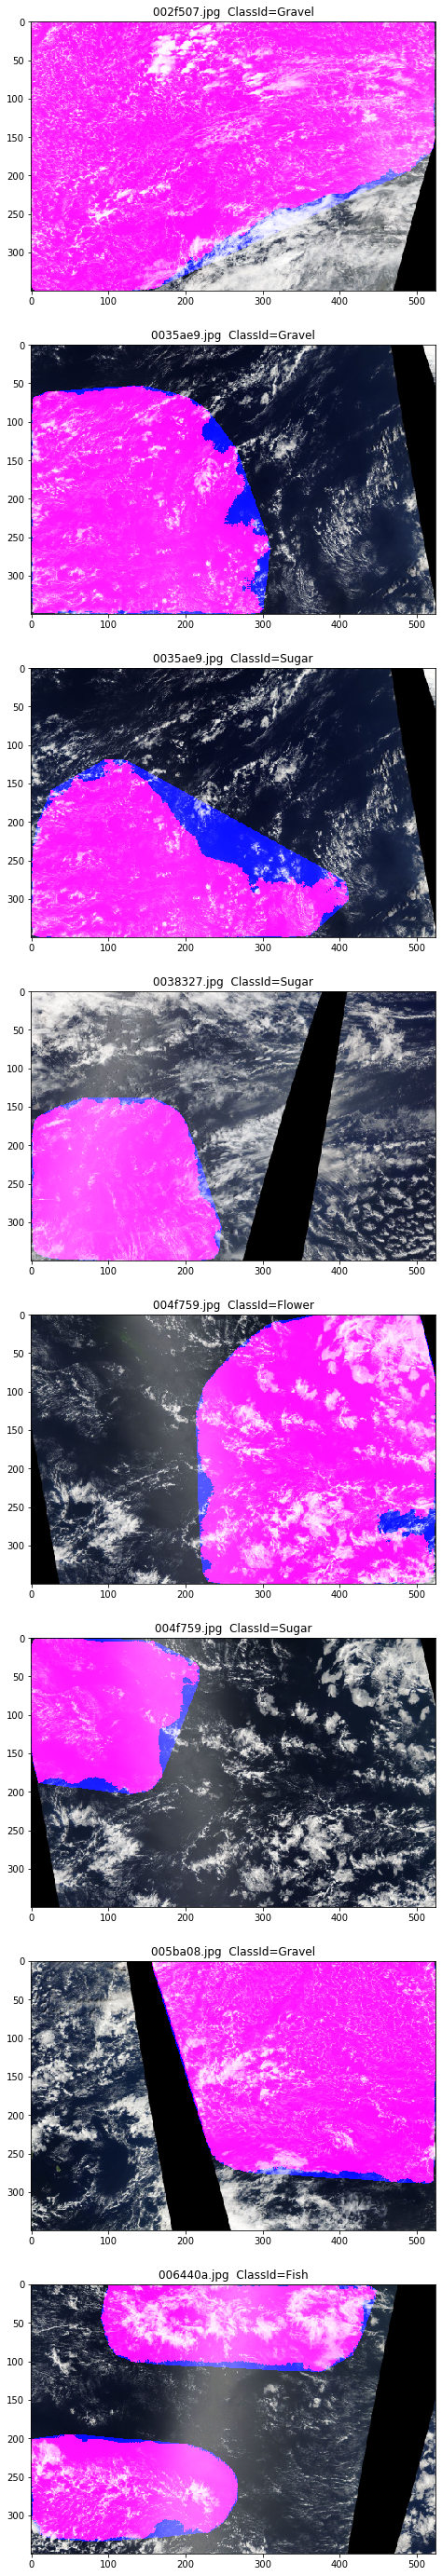

In [81]:
from skimage.morphology import convex_hull_image, convex_hull_object

rows = 8
fig = plt.figure(figsize=(50, 50))
for i in range(0, rows):
    fn = df_submission['Filename'].iloc[i]
    c = df_submission['ClassId'].iloc[i]
    fig.add_subplot(rows, 1, i + 1).set_title(fn +"  ClassId=" + str(c))
    img = cv2.imread( './input/test_images/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (525, 350), interpolation=cv2.INTER_AREA)
    mask = rle2mask(df_submission['EncodedPixels'].iloc[i], img.shape)
    print(img.shape)
#    chull = convex_hull_image(mask, offset_coordinates=False, tolerance=0.1)
    chull = convex_hull_object(mask, connectivity=1)
    img[mask==1,0] = 255
    img[chull==1,2] = 255
    plt.imshow(img)
plt.show()

### Manipulate masks

In [14]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [15]:
new_mask_submission = pd.read_csv('./input/most_accurate_1filtersing_results/new_masks_submission_06614.csv')
new_mask_submission.head(7)

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,NaN
1,002f507.jpg_Flower,NaN
2,002f507.jpg_Gravel,5 337 353 343 702 346 1052 347 1401 348 1751 3...
3,002f507.jpg_Sugar,NaN
4,0035ae9.jpg_Fish,NaN
5,0035ae9.jpg_Flower,NaN
6,0035ae9.jpg_Gravel,159 5 165 1 181 7 197 4 441 8 453 9 495 75 571...


In [16]:
counter = 0 
for index, row in new_mask_submission.iterrows():
    counter += 1
    if counter > 7:
        break
    if len(str(row['EncodedPixels'])) > 3:
        print('~~~ *** Next one is a mask')
        print(row['Image_Label'], row['EncodedPixels'])

~~~ *** Next one is a mask
002f507.jpg_Gravel 5 337 353 343 702 346 1052 347 1401 348 1751 349 2101 349 2451 349 2801 349 3151 349 3501 349 3851 349 4201 349 4551 349 4901 349 5251 349 5601 349 5951 349 6301 349 6651 349 7001 349 7351 349 7701 349 8051 349 8401 349 8751 349 9101 349 9451 349 9801 349 10151 349 10501 349 10851 349 11201 349 11551 349 11901 349 12251 349 12601 349 12951 349 13301 349 13651 349 14001 349 14351 349 14701 349 15051 349 15401 349 15751 349 16101 349 16451 349 16801 349 17151 349 17501 349 17851 349 18201 349 18551 349 18901 349 19251 349 19601 349 19951 349 20301 349 20651 349 21001 349 21351 349 21701 349 22051 349 22401 349 22751 349 23101 349 23451 349 23801 349 24151 349 24501 349 24851 349 25201 349 25551 349 25901 349 26251 349 26601 349 26951 349 27301 349 27651 349 28001 349 28351 349 28701 349 29051 349 29401 349 29751 349 30101 349 30451 349 30801 349 31151 349 31501 349 31851 349 32201 349 32551 349 32901 349 33251 349 33601 349 33951 349 34301 34

Index: 0
Index: 1
Index: 2
~~~ *** Next one is a mask
002f507.jpg_Gravel 5 337 353 343 702 346 1052 347 1401 348 1751 349 2101 349 2451 349 2801 349 3151 349 3501 349 3851 349 4201 349 4551 349 4901 349 5251 349 5601 349 5951 349 6301 349 6651 349 7001 349 7351 349 7701 349 8051 349 8401 349 8751 349 9101 349 9451 349 9801 349 10151 349 10501 349 10851 349 11201 349 11551 349 11901 349 12251 349 12601 349 12951 349 13301 349 13651 349 14001 349 14351 349 14701 349 15051 349 15401 349 15751 349 16101 349 16451 349 16801 349 17151 349 17501 349 17851 349 18201 349 18551 349 18901 349 19251 349 19601 349 19951 349 20301 349 20651 349 21001 349 21351 349 21701 349 22051 349 22401 349 22751 349 23101 349 23451 349 23801 349 24151 349 24501 349 24851 349 25201 349 25551 349 25901 349 26251 349 26601 349 26951 349 27301 349 27651 349 28001 349 28351 349 28701 349 29051 349 29401 349 29751 349 30101 349 30451 349 30801 349 31151 349 31501 349 31851 349 32201 349 32551 349 32901 349 33251 349 3

125 139 434 252 774 271 1120 277 1469 280 1818 281 2168 281 2518 281 2867 282 3217 282 3566 283 3916 283 4265 284 4615 284 4965 284 5314 285 5664 285 6013 286 6363 286 6712 287 7062 287 7412 287 7762 287 8112 287 8462 287 8811 288 9161 288 9511 288 9861 288 10211 288 10561 288 10911 288 11261 288 11611 288 11961 288 12311 288 12661 288 13010 289 13360 289 13710 289 14060 289 14410 289 14760 289 15110 289 15460 289 15810 289 16160 289 16510 289 16860 289 17210 289 17560 289 17910 289 18259 290 18609 291 18959 291 19309 291 19659 291 20009 291 20359 291 20709 291 21059 291 21409 291 21759 291 22109 291 22459 291 22809 291 23158 292 23508 292 23858 292 24208 292 24558 292 24908 292 25258 292 25608 292 25958 292 26308 292 26658 292 27008 292 27358 292 27708 292 28058 292 28407 293 28757 293 29107 293 29457 293 29807 293 30157 293 30507 293 30857 293 31207 293 31557 293 31907 293 32257 293 32607 293 32957 293 33307 293 33656 294 34006 294 34356 294 34706 294 35056 294 35406 294 35756 294 36

287 45 597 92 937 107 1279 118 1623 125 1967 131 2311 138 2655 144 3001 148 3349 151 3697 153 4044 156 4392 158 4739 161 5087 163 5435 165 5782 168 6130 170 6477 173 6825 175 7173 177 7520 180 7868 182 8215 185 8563 187 8911 189 9259 191 9608 192 9958 192 10307 193 10657 193 11006 194 11356 194 11705 195 12054 196 12404 196 12753 197 13103 197 13452 198 13801 199 14151 199 14500 200 14850 200 15199 201 15549 201 15898 202 16247 203 16597 203 16946 204 17296 204 17645 205 17994 206 18344 206 18693 207 19043 207 19392 208 19742 208 20091 209 20440 210 20790 210 21139 211 21489 211 21838 212 22188 212 22537 213 22886 214 23236 214 23585 215 23935 215 24284 216 24634 216 24983 217 25333 217 25682 218 26031 219 26381 219 26730 220 27080 220 27429 221 27779 221 28128 222 28477 223 28827 223 29176 224 29526 224 29875 225 30225 225 30574 226 30924 226 31273 227 31622 228 31972 228 32321 229 32671 229 33020 230 33370 230 33719 231 34069 231 34419 231 34769 231 35119 231 35469 231 35819 231 3616

75025 34 75372 65 75719 96 76066 128 76413 159 76759 191 77106 211 77453 220 77800 229 78147 238 78495 243 78843 247 79191 251 79540 253 79888 257 80237 259 80586 261 80935 262 81283 265 81632 266 81981 267 82330 269 82678 271 83027 272 83376 273 83725 274 84074 275 84422 277 84771 279 85120 280 85469 281 85818 282 86167 283 86516 284 86865 285 87214 286 87563 287 87912 288 88261 289 88609 291 88958 292 89307 293 89656 294 90005 295 90354 296 90703 297 91052 298 91401 299 91750 300 92099 301 92448 302 92797 303 93146 304 93495 305 93844 306 94193 307 94542 308 94891 309 95241 309 95590 310 95939 311 96288 312 96637 313 96986 314 97336 314 97685 315 98034 316 98383 317 98732 318 99081 319 99431 319 99780 320 100129 321 100478 322 100828 322 101177 323 101526 324 101875 325 102225 325 102574 326 102923 327 103272 328 103622 328 103971 329 104320 330 104670 330 105019 331 105368 332 105718 332 106067 333 106416 334 106766 334 107115 335 107465 335 107814 336 108163 337 108513 337 108862 3

54953 5 55302 10 55652 13 56002 17 56352 20 56702 23 57051 27 57401 30 57751 34 58101 37 58451 40 58801 43 59151 47 59501 50 59851 53 60201 56 60551 59 60901 63 61251 66 61601 69 61951 72 62301 76 62651 79 63001 82 63351 85 63701 88 64051 92 64401 95 64751 98 65101 101 65451 105 65801 108 66151 111 66501 114 66851 117 67201 121 67551 124 67901 127 68251 130 68601 134 68951 137 69301 140 69651 143 70001 147 70351 150 70701 153 71051 156 71401 159 71751 163 72101 166 72451 169 72801 172 73151 176 73501 179 73851 182 74201 185 74551 188 74901 192 75251 195 75601 198 75951 201 76301 205 76651 208 77001 211 77351 214 77701 217 78051 221 78401 224 78751 227 79101 230 79451 233 79801 235 80151 238 80501 241 80851 243 81201 246 81551 248 81901 250 82251 251 82601 252 82951 253 83301 255 83651 256 84001 257 84351 258 84701 259 85051 260 85401 261 85751 261 86101 262 86451 262 86801 263 87151 263 87501 264 87851 264 88201 265 88551 265 88901 266 89251 266 89601 266 89951 267 90301 267 90651 268 

205 72 552 103 901 106 1251 108 1601 110 1950 113 2300 115 2650 117 3000 119 3350 121 3700 123 4049 126 4399 127 4749 127 5099 128 5449 128 5799 129 6149 129 6499 129 6848 131 7198 131 7548 131 7898 131 8248 132 8598 132 8948 132 9298 133 9648 133 9998 133 10347 134 10697 134 11047 134 11397 134 11747 134 12097 134 12447 135 12797 135 13147 135 13496 136 13846 136 14196 136 14546 136 14896 136 15246 136 15596 136 15946 136 16296 136 16646 136 16995 137 17345 137 17695 137 18045 138 18395 138 18745 138 19095 138 19445 138 19795 138 20145 138 20495 138 20845 138 21196 137 21546 137 21896 137 22246 137 22596 137 22946 137 23296 137 23646 138 23996 138 24346 138 24696 138 25046 138 25397 137 25747 137 26097 137 26447 137 26797 137 27147 137 27497 137 27847 137 28197 137 28547 137 28897 137 29247 137 29598 136 29948 136 30298 136 30648 136 30998 136 31348 136 31698 136 31891 7 32048 136 32233 19 32398 136 32576 30 32748 136 32920 40 33098 136 33266 48 33448 136 33613 54 33799 135 33961 59 3

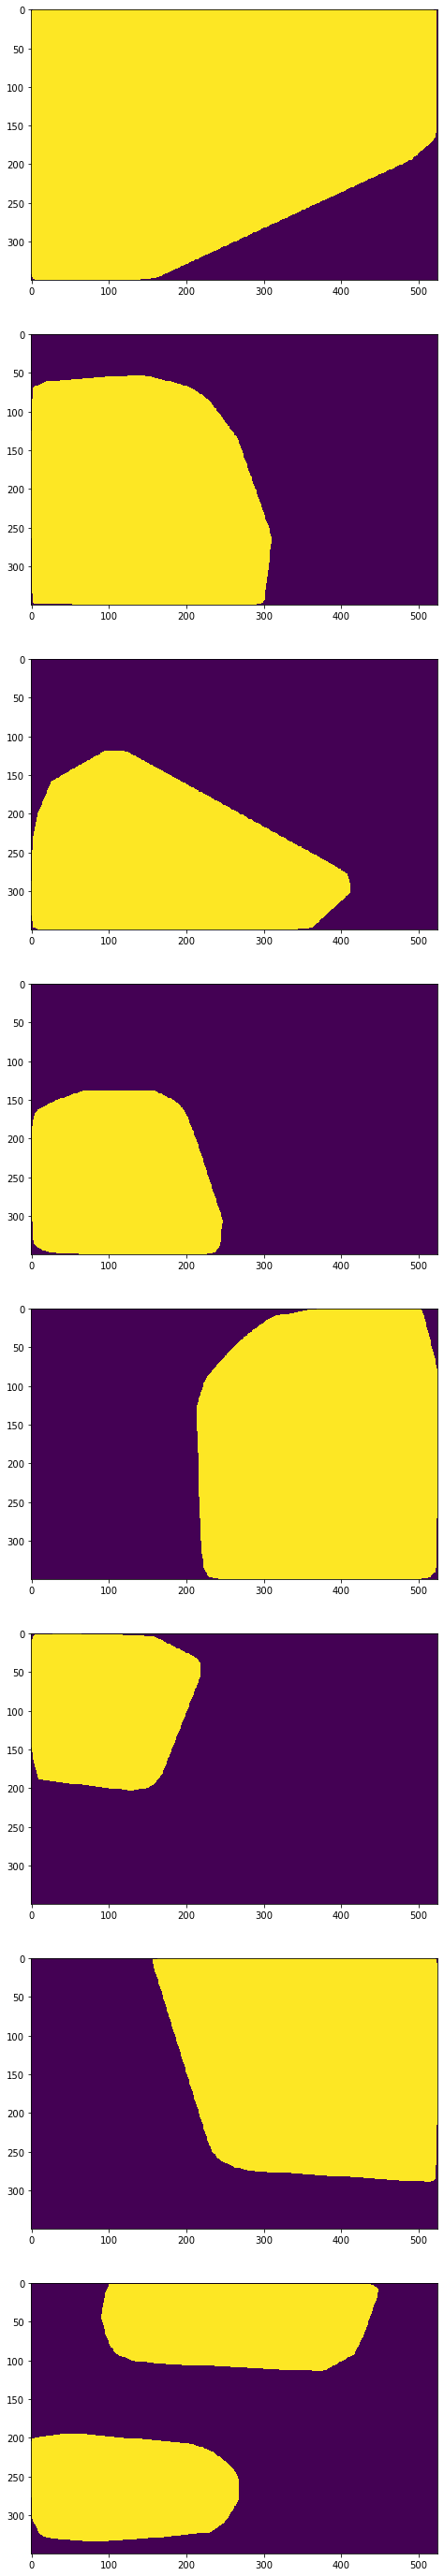

In [98]:
fig = plt.figure(figsize=(50, 50))

counter = 0 
row_no = 0
for index, row in new_mask_submission.iterrows():
    print(f'Index: {index}')
    counter += 1
    if counter > 21:
        break
    if len(str(row['EncodedPixels'])) > 3:
        print('~~~ *** Next one is a mask')
        print(row['Image_Label'], row['EncodedPixels'])
        fig.add_subplot(8, 1, row_no + 1)
        mask = rle2mask(row['EncodedPixels'], (350, 525))
        chull = convex_hull_object(mask, connectivity=1)
        new_rle = mask2rle(chull)
        print(new_rle)
        plt.imshow(chull)
        row_no += 1

plt.show()

        

In [17]:
new_mask_submission.shape

(14792, 2)

In [22]:
from skimage.morphology import convex_hull_image, convex_hull_object

for index, row in new_mask_submission.iterrows():
    if index < 8000:
        continue
    if index % 100 == 0:
        print(index)
    if len(str(row['EncodedPixels'])) > 3:
        #print('Start rle2mask')
        mask = rle2mask(row['EncodedPixels'], (350, 525))
        #print('Start chull')
        chull = convex_hull_object(mask, connectivity=1)
        #print('Start mask2rle')
        new_rle = mask2rle(chull)
        row['EncodedPixels'] = new_rle
    if index % 1000 == 0:
        new_mask_submission.to_csv('submission_0_6614_8000_' + str(index) + '.csv', index=None)

    

8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700


In [23]:
new_mask_submission.to_csv('submission_0_6614_8000_all_data.csv', index=None)

In [ ]:
new_mask_submission.head(10)

# Future work
1. estimate distribution of classes in test set using the classifier. Then, if necessary and doable, modify val set accordingly,
2. use the classifier with explainability technique [Gradient-weighted Class Activation Mapping](http://gradcam.cloudcv.org/) to generate a baseline, (please see [GradCAM: extracting masks from classifier](https://www.kaggle.com/samusram/gradcam-extracting-masks-from-classifier)),
3. improve the classifier,
4. use the classifier as backbone for UNet-like solution.